In [1]:
import numpy as np

from matplotlib import pyplot as plot, colors
%matplotlib inline

from mpl_toolkits import basemap
from netCDF4 import Dataset, num2date

In [2]:
# Input file and data visualization settings
file = 'GS201802_SST_NW_month.nc'
varname = 'sst'
font_size = 20
cmin, cmax = 0.01, 100
# for CHL we use lognorm
norm = colors.LogNorm(cmin, cmax)
# update the size of figure labels
plot.rcParams.update({'font.size': font_size})

In [3]:
# Read the dataset and geo-ref data
with Dataset(file, 'r') as nc:
    sds = nc[varname][:] # the output is a numpy masked array
    sds = np.ma.squeeze(sds) # remove singleton dimensions
    label = nc[varname].units.replace('^-3', '$^{-3}$')
    lat = nc['lat'][:]
    lon = nc['lon'][:]
    time = num2date(nc['time'][:], 
                    units=nc['time'].units,
                    calendar=nc['time'].calendar)
    label = nc[varname].long_name.split(',')[0] + f' [{label}]'

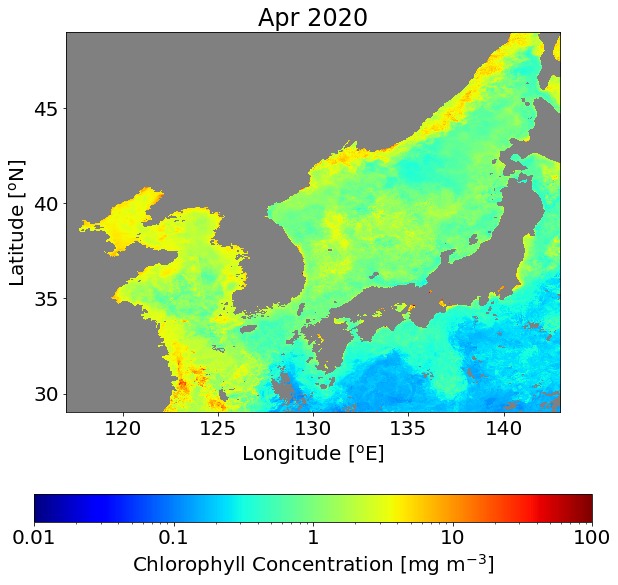

In [14]:
# Visualisation with out basemap
plot.figure(figsize=(10, 10))
# figure bounds
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

# Land mask
mask = np.where(~sds.mask, np.nan, 0)
plot.imshow(mask, cmap='gray', vmin=-1, vmax=1, extent=extent)

# Data 
ims = plot.imshow(sds, cmap='jet', vmin=cmin, vmax=cmax, extent=extent, norm=norm)

# Figure labels
plot.xlabel('Longitude [$^\mathregular{o}$E]')
plot.ylabel('Latitude [$^\mathregular{o}$N]')
plot.yticks(range(30, 50, 5))
plot.title(time[0].strftime('%b %Y'))

# Colourbar
plot.colorbar(ims, orientation='horizontal', aspect=20, label=label, format='%g')

# save to file
svf = f'{file[:-3]}.png'
plot.savefig(svf, dpi=300)

# close
# plot.close()

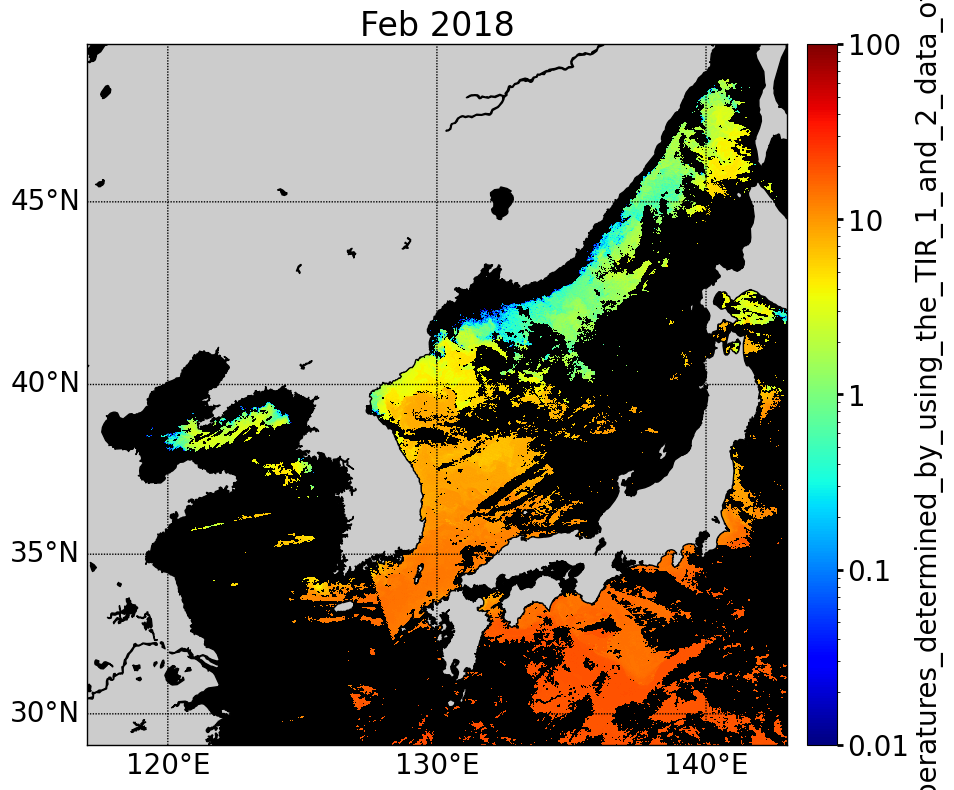

In [6]:
# Visualisation with basemap
if len(lon.shape) == 1:
    lon, lat = np.meshgrid(lon, lat)
lon_0, lat_0 = (lon.min() + lon.max()) / 2, (lat.min() + lat.max()) / 2
m = basemap.Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(), 
                    urcrnrlon=lon.max(), urcrnrlat=lat.max(), resolution='i', 
                    lon_0=lon_0, lat_0=lat_0, projection='merc')
# optional, to change the figure size
fig = plot.figure(figsize=(10, 10 * m.aspect))
ax = fig.add_axes([0.08, 0.1, 0.7, 0.7], facecolor='white') 

mx, my = m(lon, lat)
pm = m.pcolormesh(mx, my, sds, norm=norm, cmap=plot.cm.jet)
plot.title(time[0].strftime('%b %Y'))

# colourbar with axes set to match figure size
cax = plot.axes([0.8, 0.1, 0.03, 0.7]) # setup colorbar axes
cb = plot.colorbar(pm, label=label, cax=cax, format='%g') # draw colorbar
cb.ax.tick_params(width=2, length=4)

plot.sca(ax)  # make the original axes current again
plot.clim(cmin, cmax)

m.drawparallels(range(30, 50, 5), labels=[True, False, False, False])
m.drawmeridians(range(120, 150, 10), labels=[0, 0, 0, 1])
m.fillcontinents(lake_color='black')  # Fill the continents ',
m.drawmapboundary(fill_color='black')  # Fill the globe with a blue color
m.drawcoastlines()
            
# to visualise
plot.show()